In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('homepage_actions.csv')
df.head(10)

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
3,2016-09-24 19:59:02.646620,671993,control,view
4,2016-09-24 20:26:14.466886,536734,experiment,view
5,2016-09-24 20:32:25.712659,681598,experiment,view
6,2016-09-24 20:39:03.248853,522116,experiment,view
7,2016-09-24 20:57:20.336757,349125,experiment,view
8,2016-09-24 20:58:01.948663,349125,experiment,click
9,2016-09-24 21:00:12.278374,560027,control,view


As seen above, this dataset includes view and click actions on the home page of Audacity's site, from users that were shown the control and experimental versions of A/B test. The first change Audacity wants to try is on their home page. They hope that this new, more engaging design will increase the number of users that explore their courses.

### 1. Match the following characteristics of this dataset: 
- total number of actions
- number of unique users
- sizes of the control and experiment groups (i.e., the number of unique users in each group)

In [75]:
# total number of actions
df.shape[0]

8188

In [76]:
# number of unique users
df.nunique()

timestamp    8188
id           6328
group           2
action          2
dtype: int64

In [77]:
# size of control group and experiment group
df.groupby('group').nunique()

,timestamp,id,group,action
group,,,,
control,4264,3332,1,2
experiment,3924,2996,1,2


### 2. How long was the experiment run for? 
Hint: the records in this dataset are ordered by timestamp in increasing order

In [78]:
# duration of this experiment
df.timestamp.max(), df.timestamp.min()

('2017-01-18 10:24:08.629327', '2016-09-24 17:42:27.839496')

### 3. What action types are recorded in this dataset?
(i.e., What are the unique values in the action column?)

In [79]:
# action types in this experiment
df.action.unique()

array(['view', 'click'], dtype=object)

### 4. Why would we use click through rate instead of number of clicks to compare the performances of control and experiment pages?

1. The control and experiment pages could have different number of total visitors.
2. More total clicks could occur in one version, even if there is a greater percentage of clicks in the other version.

### 5. Define the click through rate (CTR) for this experiment.

The number of unique visitors who click at least once divided by the number of unique visitors who view the page.

### 6. What are the null and alternative hypotheses?
Use $CTR_{old}$ and $CTR_{new}$ in your hypotheses.

H_0: CTR_{new} - CTR_{old} <= 0

H_1: CTR_{new} - CTR_{old} > 0

Our task is to analyze these actions to see if there was a significant difference in performance for the two versions. To do this, let's first compute the click-through rate for each group.

In [80]:
control_df = df.query('group == "control"')

In [81]:
control_ctr = control_df.query('action == "click"').id.nunique() / control_df.query('action == "view"').id.nunique()

In [82]:
control_ctr

0.2797118847539016

In [83]:
experiment_df = df.query('group == "experiment"')

In [84]:
experiment_ctr = experiment_df.query('action == "click"').id.nunique() / experiment_df.query('action == "view"').id.nunique()

In [85]:
experiment_ctr

0.3097463284379172

In [86]:
obs_diff = experiment_ctr - control_ctr
obs_diff

0.030034443684015644

So, in this sample, the experiment group's click-through rate was higher than the control group's click-through rate by about 3 percent. Now that we know the observed difference in this sample, we have to see if this difference is significant and not just due to chance. Let's bootstrap the sample to simulate the sampling distributions for the difference in proportions.

In [87]:
diffs = []

for _ in range(10000):
    b_samp = df.sample(df.shape[0], replace=True)
    control_df = b_samp.query('group == "control"')
    experiment_df = b_samp.query('group == "experiment"')
    control_ctr = control_df.query('action == "click"').id.nunique() / control_df.query('action == "view"').id.nunique()
    experiment_ctr = experiment_df.query('action == "click"').id.nunique() / experiment_df.query('action == "view"').id.nunique()
    diffs.append(experiment_ctr - control_ctr)

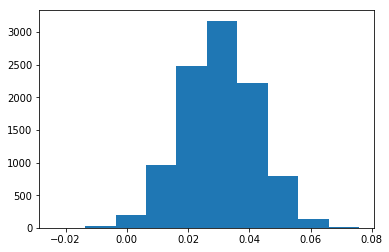

In [88]:
plt.hist(diffs);

We can compute the p-value for our statistic which is the observed difference in proportions by simulating the distribution under the null hypothesis and then finding the probability that our statistic came from this distribution. To simulate from the null, we'll create a normal distribution centered at 0, with the same standard deviation as our sampling distribution we simulated here.

In [89]:
diffs = np.array(diffs)
null_vals = np.random.normal(0, diffs.std(), diffs.size)

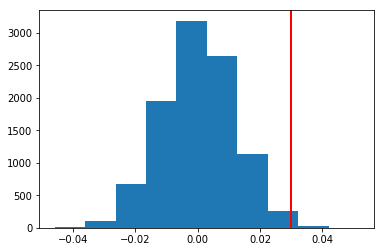

In [90]:
plt.hist(null_vals)
plt.axvline(x=obs_diff, color='r', linewidth=2);

We can see the null distribution above and this is where our observed statistic falls. We can find the p-value like as shown below, as these are all the null values that are more extreme than our statistic in favour of our alternative.

In [91]:
(null_vals > obs_diff).mean()

0.0052

With a p-value of approximately a half of percent, the difference in click-through rates for the control and experiment groups does appear to be significant. We can reject the null hypothesis, and based on these results, it looks like Audacity should launch the new version of the home page.

Let's recap the steps we took to analyze the results of this A/B test.

- We computed the observed difference between the metric, click through rate, for the control and experiment group.
- We simulated the sampling distribution for the difference in proportions (or difference in click through rates).
- We used this sampling distribution to simulate the distribution under the null hypothesis, by creating a random normal distribution centered at 0 with the same spread and size.
- We computed the p-value by finding the proportion of values in the null distribution that were greater than our observed difference.
- We used this p-value to determine the statistical significance of our observed difference.